# Raw Loss Plots

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
#mpl.use('pdf')
import sys
sys.path.append("../")
import copy
from Plotting.generate_database import ResultsDatabaseGenerator
from common_packages.utilities import get_equivalent_classical_layer_size, get_num_parameters_per_quantum_layer
from Plotting.Plot import BasicPlot, MultiPlot
import pandas as pd
import seaborn as sns
# colors =   ["#5dd448",
#             "#bfa900",
#             "#ec742f",
#             "#e9496f",
#             "#b04ca4",]
palette = sns.color_palette('pastel')
colors = palette.as_hex()

sns.set_style('ticks')

#colors = ["#332288", "#88CCEE", "#44AA99", "#117733", "#999933", "#DDCC77", "#CC6677", "#882255", "#AA4499"]
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = 10
plt.rcParams["axes.linewidth"] = 0.5




2023-11-23 17:16:47.036542: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib64:
2023-11-23 17:16:47.036856: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


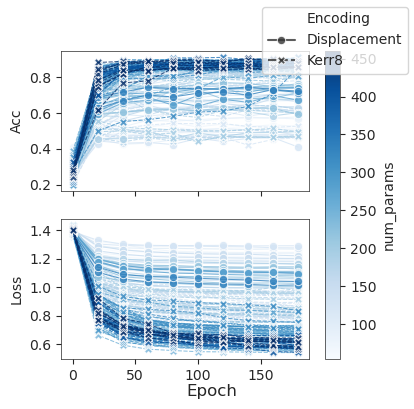

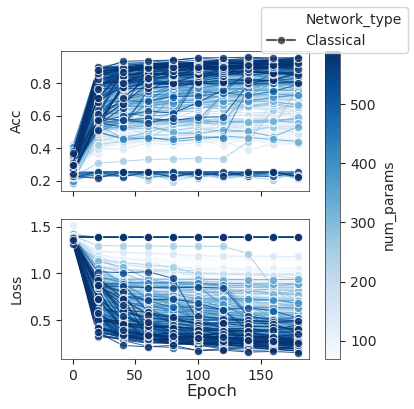

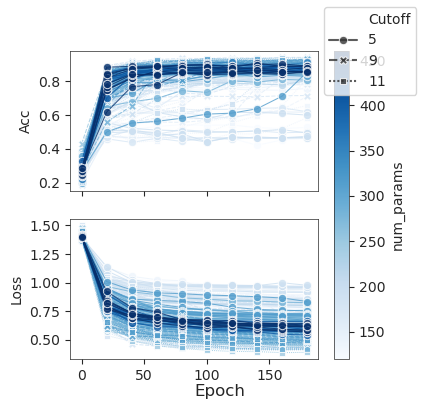

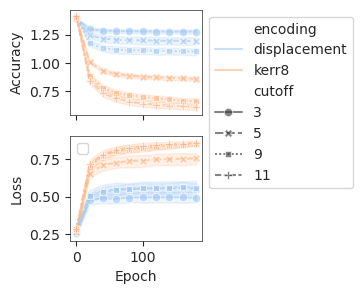

In [3]:
def plot_raw_data(df, metrics=['loss', 'val_loss'], 
                  hue='network_type', 
                  style=None,
                  size=5.0, 
                  cm=False 
):
    if cm:
        norm = plt.Normalize(df[hue].min(), df[hue].max())
        palette = sns.color_palette('Blues', as_cmap=True)
        sm = plt.cm.ScalarMappable(cmap=palette, norm=norm)
        fig, axs = plt.subplots(len(metrics),1, figsize=(4, 4), sharex=True, sharey=False)
        try:
            axs_dict = dict(zip(metrics, axs))
        except TypeError:
            axs_dict = {metrics[0]: axs}
        for metric in metrics:
            ax=axs_dict[metric]
            sns.lineplot(df, x='epoch', 
                         y=metric, ax=ax, 
                         hue=hue, style=style, 
                         alpha=0.8, size=size, 
                         palette=palette, markers=True, 
                         err_style='bars', errorbar=None,
                         units='iteration', estimator=None)
            ax.get_legend().remove()
            ax.set_xlabel('')
            ax.legend = None
            ax.set_ylabel(metric.capitalize())
        fig.supxlabel('Epoch')
        fig.colorbar(sm, ax=axs, orientation='vertical', label=hue)
        try:
            handles, labels = axs[0].get_legend_handles_labels() 
        except TypeError:
            handles, labels = axs.get_legend_handles_labels()
        legend = {'handles': [], 'labels': []}
        allowed_style_labels = [str(i) for i in df[style].unique()] + [style]
        for i in range(len(labels)):
            if labels[i] in allowed_style_labels:
                legend['handles'].append(handles[i])
                legend['labels'].append(labels[i].capitalize())
        fig.legend(**legend)
    else:
        for metric in metrics:
            fig, ax = plt.subplots(1,1, figsize=(3.0, 1.5))
            sns.lineplot(df, x='epoch', y=metric, hue=hue, style=style, alpha=0.6, markers=False)
         

df = pd.read_pickle('df_full.pkl')
df.drop_duplicates(subset=['network_type', 'num_qumodes', 'cutoff', 'n_layers', 'iteration', 'num_params'], inplace=True)
df['epoch'] = [np.arange(0,200,1) for i, row in df.iterrows()]
df['log_acc'] = df['acc'].apply(lambda x: np.log10(x))
df_exp = df.explode(column=['acc', 'val_acc', 'loss', 'val_loss', 'log_acc', 'epoch'])
df_exp.reset_index(inplace=True)
df_exp.pop('index')
df_exp.drop(df_exp.loc[(df_exp['epoch'] % 20 != 0)].index, inplace=True)
df_exp.loc[df_exp['cutoff'] == 'classical','cutoff'] = -1
df_plotd = df_exp.loc[(df_exp['encoding']=='displacement') & 
                      (df_exp['network_type'] == 'quantum')&
                      (df_exp['num_qumodes'] == 2) & 
                      (df_exp['cutoff'] % 3 == 0)]
df_plotk = df_exp.loc[(df_exp['encoding']=='kerr') & 
                      (df_exp['network_type'] == 'quantum') &
                      (df_exp['num_qumodes'] == 3)  
                      ]
df_plotk8 = df_exp.loc[(df_exp['encoding']=='kerr8')
                       #(df_exp['iteration'] <= 10) 
                       ]

                   
df_exp.drop(df_exp.loc[(df_exp['encoding']=='kerr')].index, inplace=True)
df_plotf = df_exp.loc[(df_exp['network_type'] == 'quantum') 
                       #& (df_exp['num_qumodes']== 2) 
                       & (df_exp['cutoff'] == 5)
                      ]

plot_raw_data(df_plotf, hue='num_params', style='encoding', metrics=['acc', 'loss'], cm=True, size=1.0)
df_plotf = df_exp.loc[(df_exp['network_type'] == 'quantum') 
                       & (df_exp['num_qumodes']== 2) 
                      # & (df_exp['cutoff'] == 5)
                      ]
df_plotf_classical = df_exp.loc[
                        df_exp['network_type'] == 'classical' 
                      ]
# plot_raw_data(df_plotd, hue='n_layers', style='cutoff', metrics=['acc', 'loss'])
# plot_raw_data(df_plotk, hue='num_params', style='cutoff', metrics=['acc', 'loss'], cm=True)
# plot_raw_data(df_plotf, hue='num_params', style='encoding', metrics=['acc', 'loss'], cm=True)
#plot_raw_data(df_plotf_classical, hue='num_params', style='encoding', metrics=['acc', 'loss'], cm=True)
#plot_raw_data(df_plotk8[(df_plotk8['num_qumodes'] == 2)], hue='network_type', metrics=['acc', 'loss'], cm=False, size=1.0)
#plt.savefig('k8_loss.svg', bbox_inches='tight')
# plot_raw_data(df_plotk8[(df_plotk8['num_qumodes'] == 2)], hue='num_params', style='network_type', metrics=['acc'], cm=True, size=1.0)
# plot_raw_data(df_plotk8[(df_plotk8['num_qumodes'] == 3)], hue='num_params', style='network_type', metrics=['acc'], cm=True, size=1.0)
# plot_raw_data(df_plotk8[(df_plotk8['num_qumodes'] == 4)], hue='num_params', style='network_type', metrics=['acc'], cm=True, size=1.0)
plot_raw_data(df_plotk8[df_plotk8['network_type']=='classical'], hue='num_params', style='network_type', metrics=['acc', 'loss'], cm=True, size=1.0)
plot_raw_data(df_plotk8[df_plotk8['network_type']=='quantum'], hue='num_params', style='cutoff', metrics=['acc', 'loss'], cm=True, size=1.0)
fig, ax = plt.subplots(2,1, figsize=(1.7, 3), sharex=True)

ax1 = sns.lineplot(df_plotf, x='epoch', y='loss', hue='encoding', style='cutoff', alpha=0.6, markers=True, ax=ax[0])
sns.lineplot(df_plotf, x='epoch', y='acc', hue='encoding', style='cutoff', alpha=0.6, markers=True, ax=ax[1], legend=None)

ax[0].set_ylabel('Accuracy')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
sns.move_legend(ax1, loc='upper left', bbox_to_anchor=(1,1))
plt.legend([])
plt.savefig('encoding_raw_acc_loss.svg', bbox_inches='tight')
plt.show()